# Central Worker Federated Learning Demonstration

This notebook demonstrates the features and relevant routes for the FFD central-worker infrastructure. The required packages are:
- requests
- numpy
- pandas
- scikit-learn
- matplotlib

In [5]:
import requests
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

/tmp/ipykernel_4880/4207880558.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Current issues:
- Concurrency with workstatus in store_worker and store_update:
```
Traceback (most recent call last):
File "/usr/local/lib/python3.11/site-packages/flask/app.py", line 1463, in wsgi_app
response = self.full_dispatch_request()
^^^^^^^^^^^^^^^^^^^^^^^^^^^^
File "/usr/local/lib/python3.11/site-packages/flask/app.py", line 872, in full_dispatch_request
rv = self.handle_user_exception(e)
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
File "/usr/local/lib/python3.11/site-packages/flask/app.py", line 870, in full_dispatch_request
rv = self.dispatch_request()
^^^^^^^^^^^^^^^^^^^^^^^
File "/usr/local/lib/python3.11/site-packages/flask/app.py", line 855, in dispatch_request
return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args) # type: ignore[no-any-return]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
File "/worker/routes/orchestration.py", line 15, in worker_status
payload = store_worker(
^^^^^^^^^^^^^
File "/worker/functions/storage.py", line 169, in store_worker
worker_status = json.load(f)
^^^^^^^^^^^^
File "/usr/local/lib/python3.11/json/__init__.py", line 293, in load
return loads(fp.read(),
^^^^^^^^^^^^^^^^
File "/usr/local/lib/python3.11/json/__init__.py", line 346, in loads
return _default_decoder.decode(s)
^^^^^^^^^^^^^^^^^^^^^^^^^^
File "/usr/local/lib/python3.11/json/decoder.py", line 337, in decode
obj, end = self.raw_decode(s, idx=_w(s, 0).end())
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
File "/usr/local/lib/python3.11/json/decoder.py", line 355, in raw_decode
raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)
```
- Possible data concurrency, when worker_df read

## Setup

Assuming you have git cloned the FFD repository, we can run a single worker infrastructure by doing the following actions:
1. Open two new terminals
2. Put the first terminal into central-node folder
3. Put the second terminal into worker-node folder
4. In both terminals, create a python virtual enviroment with:

```
python3 -m venv venv
```

5. Activate the virtual enviroments with:

```
source venv/bin/activate
```

6. Install the required packages with:

```
pip install -r requirements.txt
```
7. When packages are installed, make central and worker run with

```
python3 run.py
```

8. If logs show no errors (warnings are expected), then setup went fine. If you want to be sure, run the following blocks:

- docker build -t central:mvp .
- docker build -t worker:mvp .
- docker run -p 7600:7600 central:mvp
- docker run -p 7500:7500 worker:mvp
- docker exec -it container_id bash
- docker tag worker:mvp t9k4b5ndjok1/ffd:worker-mvp

In [44]:
export CLUSTER_NAME=work_laptop
export CLUSTER_LOCATION=60.2024478,24.962756,1000
export SYSTEM_MANAGER_URL=89.27.26.37

SyntaxError: invalid syntax (3495925990.py, line 1)

In [ ]:
response = requests.get(
    url = 'http://127.0.0.1:7600/demo'
)

print(response.status_code)

In [ ]:
response = requests.get(
    url = 'http://127.0.0.1:7500/demo'
)

print(response.status_code)

## Data

In this demonstration we will use [Synthetic Financial Datasets For Fraud Detection](https://www.kaggle.com/datasets/ealaxi/paysim1/data) data. To utilize it do the following:
1. Download the zip
2. Create a 'data' folder in the same place as this notebook and unzip the data to it
3. Rename the data into 'Fraud_Detection.csv'
4. Run the following blocks and then move the formatted_fraud_derection_data.csv into central data folder

In [ ]:
source_data_df = pd.read_csv('data/fraud_detection.csv')

In [ ]:
def formatting(
    source_df: any
) -> any:
    print('Formatting data')
    formated_df = source_df.copy()
    
    irrelevant_columns = [
        'oldbalanceOrg',
        'newbalanceOrig',
        'oldbalanceDest',
        'newbalanceDest'
    ]
    formated_df.drop(
        columns = irrelevant_columns, 
        inplace = True
    )
    print('Columns dropped')
    formated_df = pd.get_dummies(
        data = formated_df, 
        columns = ['type']
    )
    
    for column in formated_df.columns:
        if 'type' in column:
            formated_df[column] = formated_df[column].astype(int)
    print('One hot coded type')

    unique_values_orig = formated_df['nameOrig'].unique()
    unique_values_dest = formated_df['nameDest'].unique()
    
    unique_value_list_orig = unique_values_orig.tolist()
    unique_value_list_dest = unique_values_dest.tolist()

    print('Orig amount:', len(unique_value_list_orig))
    print('Dest amount:', len(unique_value_list_dest))
    
    set_orig_ids = set(unique_value_list_orig)
    set_dest_ids = set(unique_value_list_dest)
    intersection = set_dest_ids.intersection(set_orig_ids)

    print('Orig and Dest duplicates', len(intersection))
    
    set_dest_ids.difference_update(intersection)
    fixed_unique_value_list_dest = list(set_dest_ids)
    print('Fixed Dest amount:',len(fixed_unique_value_list_dest))
    
    orig_encoding_dict = {}
    index = 1
    for string in unique_value_list_orig:
        if not string in orig_encoding_dict:
            orig_encoding_dict[string] = index
            index = index + 1

    dest_encoding_dict = {}
    cont_index = len(orig_encoding_dict) + 1
    for string in fixed_unique_value_list_dest:
        if not string in dest_encoding_dict:
            dest_encoding_dict[string] = cont_index
            cont_index = cont_index + 1
    print('Orig dict amount:', len(orig_encoding_dict))
    print('Dest dict amount:', len(dest_encoding_dict))
    
    print('Orig and dest string-integer encodings created')

    string_orig_values = formated_df['nameOrig'].tolist()
    string_dest_values = formated_df['nameDest'].tolist()

    orig_encoded_values = []
    for string in string_orig_values:
        orig_encoded_values.append(orig_encoding_dict[string])

    dest_encoded_values = []
    for string in string_dest_values:
        if not string in dest_encoding_dict:
            dest_encoded_values.append(orig_encoding_dict[string])
            continue
        dest_encoded_values.append(dest_encoding_dict[string])

    formated_df['nameOrig'] = orig_encoded_values
    formated_df['nameDest'] = dest_encoded_values

    print('Orig encoded values amount:', len(orig_encoded_values))
    print('Dest encoded values amount:', len(dest_encoded_values))
    
    print('Orig and dest encodings set')

    formated_df['amount'] = formated_df['amount'].round(0).astype(int)
    print('Amount rounded')

    column_order = [
        'step',
        'amount',
        'nameOrig',
        'nameDest',
        'type_CASH_IN',
        'type_CASH_OUT',
        'type_DEBIT',
        'type_PAYMENT',
        'type_TRANSFER',
        'isFraud',
        'isFlaggedFraud'
    ]
    formated_df = formated_df[column_order]
    print('Columns reordered')
    print('Dataframe shape:', formated_df.shape)
    print('Formatting done')
    return formated_df

In [ ]:
formated_data_df = formatting(
    source_df = source_data_df
)

In [ ]:
formated_data_df.to_csv('data/Formated_Fraud_Detection_Data.csv', index = False)

## Training, logs and inference

When you have put the data into central-worker data folder, we can proceed with federated learning. We first need to set the parameters for the training found in the central-node/config.py. It shows the global parameters used for federated learning, the parameters central uses for its actions and the parameters given to all workers. From these, the parameters of intrest for this demonstration are:
- GLOBAL_PARAMETERS:
    - learning-rate = The used learning rate of the model
    - sample-rate = The amount of samples used in training batches
    - optimizer = The model optimizer
    - epochs = The amount of cycles used for training
- CENTRAL_PARAMETERS:
    - sample-pool = The amount of data used for train, test and eval
    - train-eval-ratio = The amount of data used for train and test
    - train-test-ratio = The amount of data used for train
    - max-cycles = Maximum amount of incremental cycles in learning
    - min-metric-success = Minimum amount of succesful metrics to stop learning
    - metric-thresholds = The thresholds that check if a metric passes based on set condition
- WORKER_PARAMETERS:
    - sample-pool
    - train-test-ratio
 
### Training

Its recommended that you leave the default settings for single worker demo. Befor starting the training, make central and worker run as shown by the setup. When they run as intended, it is recommeded to open up two IDEs into central and worker folders in order to monitor the changes that happen in their data, logs, models and tensors folders. Now, run the following block to start the training:

Necessery improvements:
- Enable parameter sending into central for containerisation x
- Create separate folders for training rounds to enable container reuse x
- Create folders parameters, status and metrics x
    - Parameters
        - Model
        - Central
        - Worker  
    - Status
        - Central
        - Workers
    - Metrics
        - Global
        - Local
- Gather time metrics between running functions and requests x
- Gather memory requirements x
- If possible, gather used CPU amount x

Used packages
- pip install Flask
- pip install requests
- pip install APScheduler
- pip install pandas
- pip install scikit-learn
- pip install psutil
- pip3 install torch==2.2.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [7]:
formated_data_df = pd.read_csv('data/Formated_Fraud_Detection_Data.csv')

In [10]:
formated_data_df

,step,amount,nameOrig,nameDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud,isFlaggedFraud
0,1,9840,1,7233461,0,0,0,1,0,0,0
1,1,1864,2,7735206,0,0,0,1,0,0,0
2,1,181,3,8598945,0,0,0,0,1,1,0
3,1,181,4,7880837,0,1,0,0,0,1,0
4,1,11668,5,7670940,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682,6353303,6895525,0,1,0,0,0,1,0
6362616,743,6311409,6353304,7179249,0,0,0,0,1,1,0
6362617,743,6311409,6353305,7452283,0,1,0,0,0,1,0
6362618,743,850003,6353306,7284324,0,0,0,0,1,1,0


In [25]:
parameters = {
    'model':{
        'seed': 42,
        'used-columns': [
            'amount',
            'type_CASH_IN',
            'type_CASH_OUT',
            'type_DEBIT',
            'type_PAYMENT',
            'type_TRANSFER',
            'isFraud'
        ],
        'input-size': 6,
        'target-column': 'isFraud',
        'scaled-columns': [
            'amount'
        ],
        'learning-rate': 0.05,
        'sample-rate': 0.10,
        'optimizer':'SGD',
        'epochs': 5
    },
    'central':{
        'sample-pool': 10000,
        'data-augmentation': {
            'active': True,
            'sample-pool': 50000,
            '1-0-ratio': 0.2
        },
        'eval-ratio': 0.5,
        'train-ratio': 0.8,
        'min-update-amount': 2,
        'max-cycles':3,
        'min-metric-success': 8,
        'metric-thresholds': {
            'true-positives': 50,
            'false-positives': 100,
            'true-negatives': 1000, 
            'false-negatives': 100,
            'recall': 0.40,
            'selectivity': 0.99,
            'precision': 0.80,
            'miss-rate': 0.05,
            'fall-out': 0.05,
            'balanced-accuracy': 0.85,
            'accuracy': 0.99
        },
        'metric-conditions': {
            'true-positives': '>=',
            'false-positives': '<=',
            'true-negatives': '>=', 
            'false-negatives': '<=',
            'recall': '>=',
            'selectivity': '>=',
            'precision': '>=',
            'miss-rate': '<=',
            'fall-out': '<=',
            'balanced-accuracy': '>=',
            'accuracy': '>='
        }
    },
    'worker':{
        'data-augemntation': True,
        'sample-pool': 10000,
        'data-augmentation': {
            'active': True,
            'sample-pool': 20000,
            '1-0-ratio': 0.2
        },
        'eval-ratio': 0.5,
        'train-ratio': 0.8
    }
}

In [9]:
parameters

{'model': {'seed': 42,
  'used-columns': ['amount',
   'type_CASH_IN',
   'type_CASH_OUT',
   'type_DEBIT',
   'type_PAYMENT',
   'type_TRANSFER',
   'isFraud'],
  'input-size': 6,
  'target-column': 'isFraud',
  'scaled-columns': ['amount'],
  'learning-rate': 0.05,
  'sample-rate': 0.1,
  'optimizer': 'SGD',
  'epochs': 5},
 'central': {'sample-pool': 10000,
  'data-augmentation': {'active': True,
   'sample-pool': 50000,
   '1-0-ratio': 0.2},
  'eval-ratio': 0.5,
  'train-ratio': 0.8,
  'min-update-amount': 1,
  'max-cycles': 4,
  'min-metric-success': 6,
  'metric-thresholds': {'true-positives': 50,
   'false-positives': 100,
   'true-negatives': 1000,
   'false-negatives': 100,
   'recall': 0.4,
   'selectivity': 0.99,
   'precision': 0.8,
   'miss-rate': 0.05,
   'fall-out': 0.05,
   'balanced-accuracy': 0.85,
   'accuracy': 0.99},
  'metric-conditions': {'true-positives': '>=',
   'false-positives': '<=',
   'true-negatives': '>=',
   'false-negatives': '<=',
   'recall': '>=',


In [26]:
data = formated_data_df.iloc[:50000].values.tolist()

In [17]:
data

[[1, 9840, 1, 7233461, 0, 0, 0, 1, 0, 0, 0],
 [1, 1864, 2, 7735206, 0, 0, 0, 1, 0, 0, 0],
 [1, 181, 3, 8598945, 0, 0, 0, 0, 1, 1, 0],
 [1, 181, 4, 7880837, 0, 1, 0, 0, 0, 1, 0],
 [1, 11668, 5, 7670940, 0, 0, 0, 1, 0, 0, 0],
 [1, 7818, 6, 6477257, 0, 0, 0, 1, 0, 0, 0],
 [1, 7108, 7, 8194799, 0, 0, 0, 1, 0, 0, 0],
 [1, 7862, 8, 8738506, 0, 0, 0, 1, 0, 0, 0],
 [1, 4024, 9, 6735336, 0, 0, 0, 1, 0, 0, 0],
 [1, 5338, 10, 6427877, 0, 0, 1, 0, 0, 0, 0],
 [1, 9645, 11, 8230374, 0, 0, 1, 0, 0, 0, 0],
 [1, 3100, 12, 7108455, 0, 0, 0, 1, 0, 0, 0],
 [1, 2561, 13, 6624440, 0, 0, 0, 1, 0, 0, 0],
 [1, 11634, 14, 8332954, 0, 0, 0, 1, 0, 0, 0],
 [1, 4099, 15, 7907886, 0, 0, 0, 1, 0, 0, 0],
 [1, 229134, 16, 6542593, 0, 1, 0, 0, 0, 0, 0],
 [1, 1564, 17, 6785574, 0, 0, 0, 1, 0, 0, 0],
 [1, 1158, 18, 7508533, 0, 0, 0, 1, 0, 0, 0],
 [1, 672, 19, 7879050, 0, 0, 0, 1, 0, 0, 0],
 [1, 215310, 20, 7171713, 0, 0, 0, 0, 1, 0, 0],
 [1, 1373, 21, 8038696, 0, 0, 0, 1, 0, 0, 0],
 [1, 9303, 22, 8879213, 0, 0, 1, 0, 0, 0

In [27]:
columns = formated_data_df.columns.tolist()

In [20]:
columns

['step',
 'amount',
 'nameOrig',
 'nameDest',
 'type_CASH_IN',
 'type_CASH_OUT',
 'type_DEBIT',
 'type_PAYMENT',
 'type_TRANSFER',
 'isFraud',
 'isFlaggedFraud']

In [28]:
context = {
    'parameters': parameters,
    'data': data,
    'columns': columns
}

payload = json.dumps(context)

response = requests.post(
    url = 'http://172.17.0.2:7600/context',
    json = payload
)

print(response.status_code)
print(response.text)

200
{"stored":true}



In [32]:
import json
import requests

address = {
    'central-address': 'http://172.17.0.2:7600' 
}

payload = json.dumps(address)

response = requests.post(
    url = 'http://172.17.0.6:7500/point',
    json = payload
)

print(response.status_code)

200


In [34]:
response = requests.post(
    url = 'http://172.17.0.2:7600/start'
)

print(response.status_code)

200


This should have changed the value of parameters/start to true in training_status.txt, which enables the the set context and pipeline background tasks to proceed. Both tasks use the training_status.txt to handle conditions, which is why it can be used for easy debugging by simply chancing and saving the values before the restart interval. 

Assuming that the worker runs fine, you now only need to wait until the value of parameters/complete in training_status.txt has changed to True. If now errors that prevented creating the model or updating the logs, you know that the federated learning happened succesfully. 

## Logs

In FFD, there are general and status logs. For general logs, you have two options for checking central and worker. The first is using the logs/central.log with IDE and the second is using a browser to read it at 'http://127.0.0.1:7600/logs'. We recommed using the first for central, while the second for workers due to easier accessability. For status logs, we can request them using the following blocks:

In [39]:
specifics = {
    'type': 'resources',
    'experiment': 1,
    'subject': 'central'
}

payload = json.dumps(specifics)

response = requests.get(
    url = 'http://127.0.0.1:7600/storage',
    json = payload
)

print(response.status_code)
logs = json.loads(response.text)
logs

200


{'data': {'function': {'1': {'1': {'cpu-percentage': 0.0,
     'disk-megabytes': 0.75781,
     'name': 'central-worker-data-split',
     'ram-megabytes': 21.70703,
     'time-seconds': 0.40845},
    '2': {'cpu-percentage': 69.8,
     'disk-megabytes': 1.35547,
     'name': 'preprocess-into-train-test-and-evalute-tensors',
     'ram-megabytes': 1.96484,
     'time-seconds': 0.19023},
    '3': {'cpu-percentage': 84.8,
     'disk-megabytes': 3.09375,
     'name': 'split-data-between-workers',
     'ram-megabytes': -2.625,
     'time-seconds': 0.75305},
    '4': {'cpu-percentage': 0.0,
     'disk-megabytes': 3.10546875,
     'name': 'initial-model-training',
     'ram-megabytes': 24.3203125,
     'time-seconds': 7.744762659072876},
    '5': {'cpu-percentage': 5.0,
     'disk-megabytes': 0.00391,
     'name': 'split-data-between-workers',
     'ram-megabytes': 11.32812,
     'time-seconds': 0.94712},
    '6': {'cpu-percentage': -4.9,
     'disk-megabytes': 0.00391,
     'name': 'update-glob

In [10]:
specifics = {
    'type': 'metrics',
    'experiment': 0,
    'subject': 'centr'
}

payload = json.dumps(specifics)

response = requests.get(
    url = 'http://127.0.0.1:7600/storage',
    json = payload
)

print(response.status_code)
all_global_metrics = json.loads(response.text)
all_global_metrics

200


{'data': {'1': {'1': {'accuracy': 0.7996,
    'balanced-accuracy': 0.53328,
    'eval-amount': 0,
    'fall-out': 0.0141,
    'false-negatives': 946,
    'false-positives': 56,
    'miss-rate': 0.91934,
    'precision': 0.59712,
    'recall': 0.08066,
    'selectivity': 0.9859,
    'test-amount': 5000,
    'train-amount': 20000,
    'true-negatives': 3915,
    'true-positives': 83},
   '2': {'accuracy': 0.8012,
    'balanced-accuracy': 0.52506,
    'eval-amount': 25000,
    'fall-out': 0.01292,
    'false-negatives': 4712,
    'false-positives': 258,
    'miss-rate': 0.93697,
    'precision': 0.5513,
    'recall': 0.06303,
    'selectivity': 0.98708,
    'test-amount': 0,
    'train-amount': 20000,
    'true-negatives': 19713,
    'true-positives': 317},
   '3': {'accuracy': 0.80536,
    'balanced-accuracy': 0.52766,
    'eval-amount': 25000,
    'fall-out': 0.00771,
    'false-negatives': 4712,
    'false-positives': 154,
    'miss-rate': 0.93697,
    'precision': 0.67304,
    'recall

In [12]:
specifics = {
    'type': 'resources',
    'experiment': 0,
    'subject': 'central'
}

payload = json.dumps(specifics)

response = requests.get(
    url = 'http://127.0.0.1:7600/storage',
    json = payload
)

print(response.status_code)
all_central_resources = json.loads(response.text)
all_central_resources

200


{'data': {'1': {'function': {'1': {'1': {'cpu-percentage': 0.0,
      'disk-megabytes': 0.74219,
      'name': 'central-worker-data-split',
      'ram-megabytes': 10.84375,
      'time-seconds': 0.4117},
     '2': {'cpu-percentage': 64.8,
      'disk-megabytes': 1.35156,
      'name': 'preprocess-into-train-test-and-evalute-tensors',
      'ram-megabytes': 5.4375,
      'time-seconds': 0.26688},
     '3': {'cpu-percentage': 0.0,
      'disk-megabytes': 0.73828,
      'name': 'split-data-between-workers',
      'ram-megabytes': 13.67578,
      'time-seconds': 0.23824},
     '4': {'cpu-percentage': 0.0,
      'disk-megabytes': 0.0078125,
      'name': 'initial-model-training',
      'ram-megabytes': 62.51953125,
      'time-seconds': 9.023850917816162},
     '5': {'cpu-percentage': 0.0,
      'disk-megabytes': 0.00391,
      'name': 'update-global-model',
      'ram-megabytes': 7.8125,
      'time-seconds': 0.01707}},
    '2': {'1': {'cpu-percentage': 0.0,
      'disk-megabytes': 0.00391

In [13]:
specifics = {
    'type': 'status',
    'experiment': 0,
    'subject': 'central'
}

payload = json.dumps(specifics)

response = requests.get(
    url = 'http://127.0.0.1:7600/storage',
    json = payload
)

print(response.status_code)
all_central_status = json.loads(response.text)
all_central_status

200


{'data': {'1': {'collective-amount': 8000,
   'complete': True,
   'cycle': 5,
   'data-split': True,
   'eval-amount': 25000,
   'evaluated': True,
   'preprocessed': True,
   'sent': True,
   'start': True,
   'test-amount': 5000,
   'train-amount': 20000,
   'trained': True,
   'updated': True,
   'worker-split': True,
   'worker-updates': 1},
  '2': {'collective-amount': 8000,
   'complete': True,
   'cycle': 5,
   'data-split': True,
   'eval-amount': 25000,
   'evaluated': True,
   'preprocessed': True,
   'sent': True,
   'start': True,
   'test-amount': 5000,
   'train-amount': 20000,
   'trained': True,
   'updated': True,
   'worker-split': True,
   'worker-updates': 1},
  '3': {'collective-amount': 8000,
   'complete': True,
   'cycle': 5,
   'data-split': True,
   'eval-amount': 25000,
   'evaluated': True,
   'preprocessed': True,
   'sent': True,
   'start': True,
   'test-amount': 5000,
   'train-amount': 20000,
   'trained': True,
   'updated': True,
   'worker-split': 

Since all workers send their metrics to central, we can just utilize its logs to plot the metrics, but if you want to check their status for debugging, you can do it with the following block:

In [39]:
specifics = {
    'type': 'metrics',
    'experiment': 0,
    'subject': 'local'
}

payload = json.dumps(specifics)

response = requests.get(
    url = 'http://127.0.0.1:7500/storage',
    json = payload
)

print(response.status_code)
all_worker_metrics = json.loads(response.text)
all_worker_metrics

200


{'data': {'1': {'1': {'accuracy': 0.7955,
    'balanced-accuracy': 0.52661,
    'eval-amount': 0,
    'fall-out': 0.01138,
    'false-negatives': 391,
    'false-positives': 18,
    'miss-rate': 0.93541,
    'precision': 0.6,
    'recall': 0.06459,
    'selectivity': 0.98862,
    'test-amount': 2000,
    'train-amount': 8000,
    'true-negatives': 1564,
    'true-positives': 27},
   '2': {'accuracy': 0.7996,
    'balanced-accuracy': 0.52181,
    'eval-amount': 10000,
    'fall-out': 0.01116,
    'false-negatives': 1915,
    'false-positives': 89,
    'miss-rate': 0.94521,
    'precision': 0.555,
    'recall': 0.05479,
    'selectivity': 0.98884,
    'test-amount': 0,
    'train-amount': 8000,
    'true-negatives': 7885,
    'true-positives': 111},
   '3': {'accuracy': 0.8155,
    'balanced-accuracy': 0.52901,
    'eval-amount': 0,
    'fall-out': 0.00742,
    'false-negatives': 357,
    'false-positives': 12,
    'miss-rate': 0.93455,
    'precision': 0.67568,
    'recall': 0.06545,
  

Now, if we want to plot the gathered metrics, we can do it using the following functions:

In [42]:
def plot_binary_classification_metrics(
    metrics_data: any, 
    title: str, 
    metrics: list
):
  
    colors = ['red', 'green', 'blue', 'orange']
    line_styles = ['-', '--', '-.', ':']
    cycles = sorted(metrics_data.keys())

    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Plotting the first two metrics on the primary y-axis
    ax1.set_xlabel('Training Cycles')
    ax1.set_ylabel(metrics[0], color=colors[0])
    ax1.plot(cycles, [metrics_data[cycle][metrics[0]] for cycle in cycles], label=metrics[0], color=colors[0], linewidth=2.5, linestyle=line_styles[0])
    ax1.tick_params(axis='y', labelcolor=colors[0])
    ax1.legend(loc='upper left')

    if len(metrics) > 1:
        ax1.set_ylabel(metrics[1], color=colors[1])
        ax1.plot(cycles, [metrics_data[cycle][metrics[1]] for cycle in cycles], label=metrics[1], color=colors[1], linewidth=2.5, linestyle=line_styles[1])
        ax1.legend(loc='upper left')

    # Setting up a secondary y-axis for the remaining metrics
    if len(metrics) > 2:
        ax2 = ax1.twinx()
        ax2.set_ylabel(metrics[2], color=colors[2])
        ax2.plot(cycles, [metrics_data[cycle][metrics[2]] for cycle in cycles], label=metrics[2], color=colors[2], linewidth=2.5, linestyle=line_styles[2])
        ax2.tick_params(axis='y', labelcolor=colors[2])
        ax2.legend(loc='upper right')

    if len(metrics) > 3:
        ax2.set_ylabel(metrics[3], color=colors[3])
        ax2.plot(cycles, [metrics_data[cycle][metrics[3]] for cycle in cycles], label=metrics[3], color=colors[3], linewidth=2.5, linestyle=line_styles[3])
        ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.title(title)
    plt.show()

def plot_performance_metrics(
    metrics_data: any, 
    title: str, 
    metrics: list
):

    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'cyan', 'magenta', 'lime', 'gray']
    line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.']
    cycles = sorted(metrics_data.keys())

    fig, ax = plt.subplots(figsize=(12, 8))

    for metric, color, line_style in zip(metrics, colors, line_styles):
        if metric in metrics_data[cycles[0]]:  # Check if the metric exists in the data
            values = [metrics_data[cycle][metric] for cycle in cycles]
            ax.plot(cycles, values, label=metric, color=color, linewidth=2.5, linestyle=line_style)

    ax.set_xlabel('Training Cycles')
    ax.set_ylabel('Metric Values')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.show()

In [43]:
central_status = central_status_dict['status']

Running this block creates plots for gathered binary confusion matrix results, where:
- True positives = Correctly predicted fraud cases
- False positives = Incorrectly predicted fraud cases
- True negatives = Correctly predicted non fraud cases
- False negatives = Incorrectly predicted non fraud cases

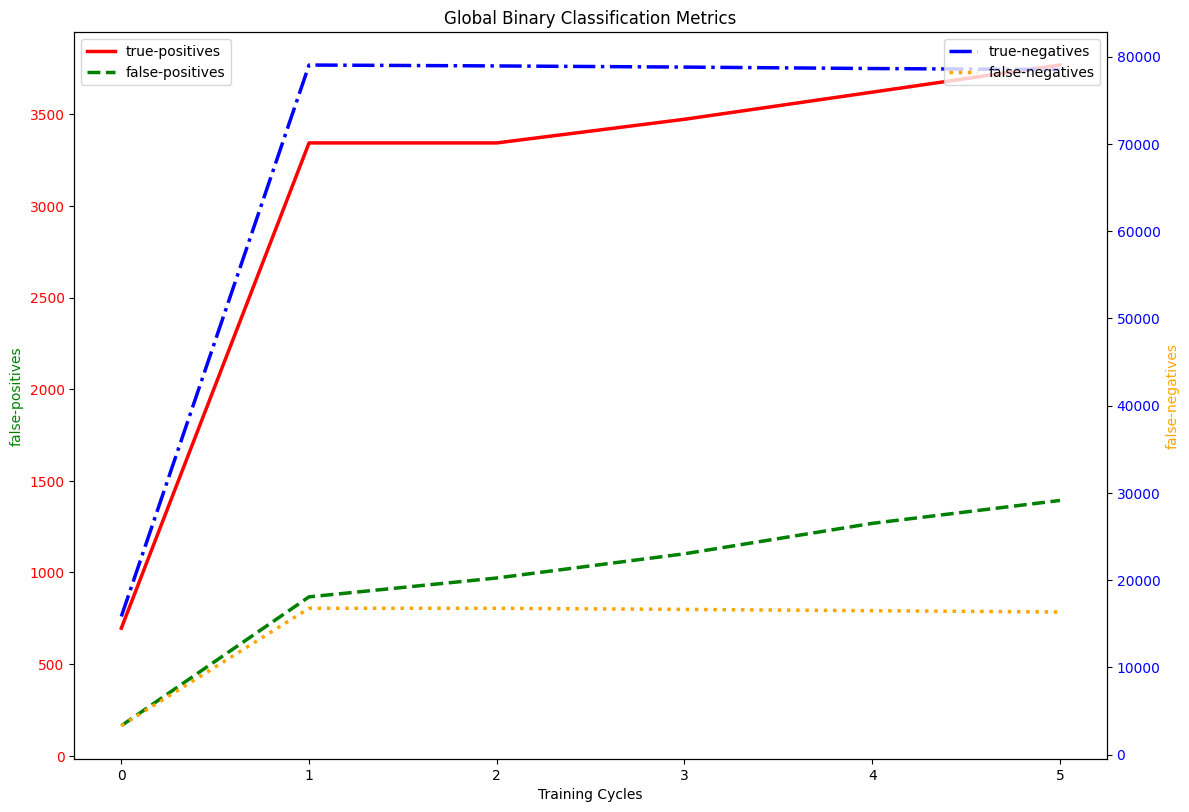

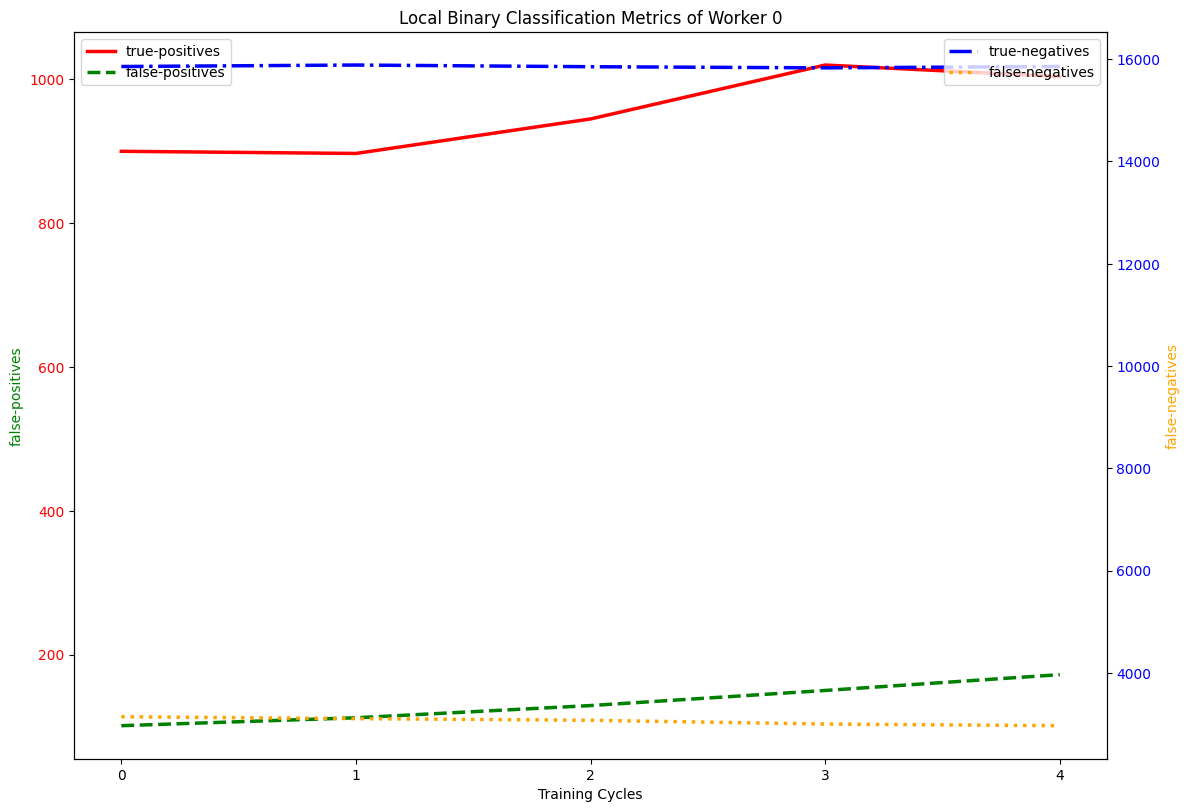

In [44]:
metrics_binary = ['true-positives', 'false-positives', 'true-negatives', 'false-negatives']
plot_binary_classification_metrics(central_status['parameters']['global-metrics'], "Global Binary Classification Metrics", metrics_binary)
plot_binary_classification_metrics(central_status['workers']['0']['local-metrics'], "Local Binary Classification Metrics of Worker 0", metrics_binary)

Running this block creates plots for the performance metrics calculated from the true-positives (TP), false-positives (FP), true negatives (TN) and false negative (FN) results, which are:
- Recall = TPR = TP/(TP+FN) -> Higher score is better
- Selectivity = TNR = TN/(TN+FP) -> Higher score is better
- Precision = TP/(TP+FP) -> Higher score is better
- Miss rate = FN/(FN+TP) -> Lower score is better
- Fall out = FP/(FP+TN) -> Lower score is better
- Balanced accuracy = (TPR+TNR)/2 -> Higher score is better
- Accuracy = (TP + TN)/(TP + TN + FP + FN) -> Higher score is better

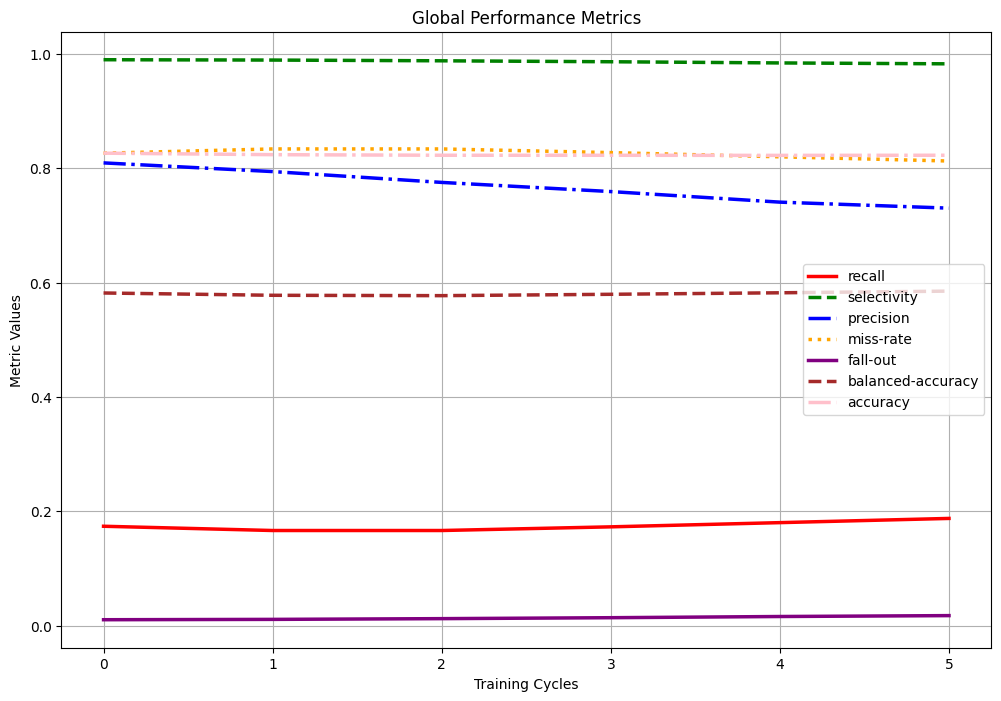

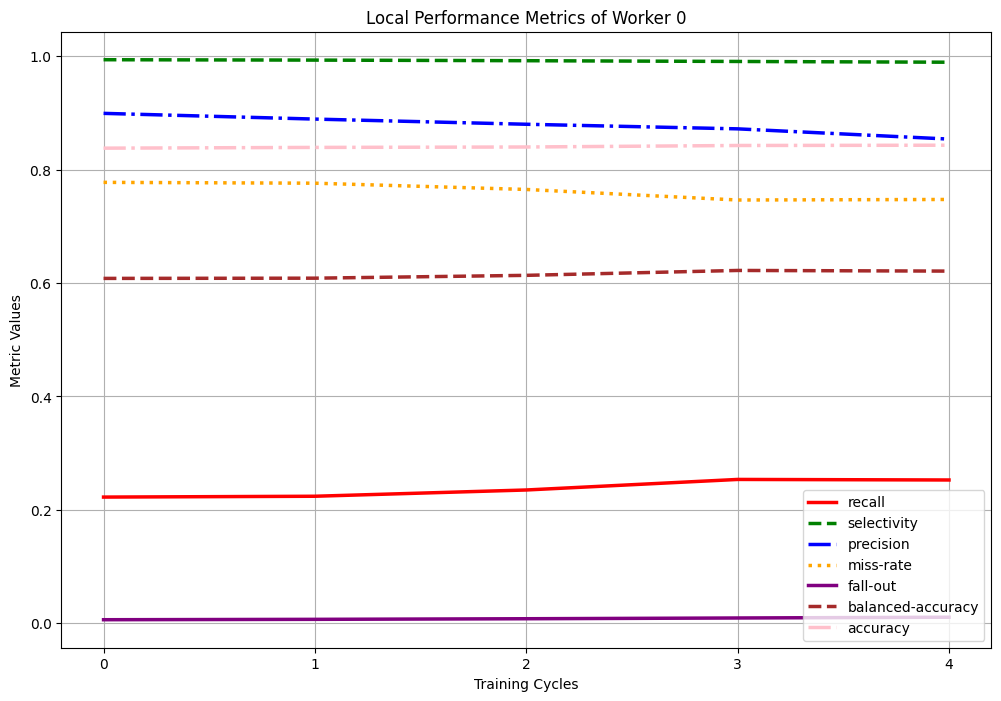

In [45]:
metrics_performance = ['recall', 'selectivity', 'precision', 'miss-rate', 'fall-out', 'balanced-accuracy', 'accuracy']
plot_performance_metrics(central_status['parameters']['global-metrics'], "Global Performance Metrics", metrics_performance)
plot_performance_metrics(central_status['workers']['0']['local-metrics'], "Local Performance Metrics of Worker 0", metrics_performance)

### Inference

If we want to test or debug either global or worker models, we can do it by sending inference requests to either central or workers. However, we need to also preprocess the data before sending it, which we can do using the following function:

In [36]:
def central_worker_inference(
    address: str,
    experiment: str,
    subject: str,
    cycle: int,
    data_df: any,
    relevant_columns: list,
    rows: int
):
    sample_df = data_df.iloc[:rows,:]
    relevant_df = sample_df[relevant_columns]
    input_df = relevant_df.iloc[:rows,:-2]
    mean = input_df['amount'].mean()
    std_dev = input_df['amount'].std()
    input_df['amount'] = (input_df['amount'] - mean)/std_dev

    payload = {
        'experiment-id': experiment,
        'subject': subject,
        'cycle': cycle,
        'input': input_df.values.tolist()
    }
    payload = json.dumps(payload)
    central_address = address + '/predict' 
    response = requests.post(
        url = central_address,
        json = payload
    )

    text_output = json.loads(response.text)
    sample_df['pred'] = np.array(text_output['predictions']).astype(int)
    return sample_df

In [16]:
formatted_df = pd.read_csv('data/Formated_Fraud_Detection_Data.csv')

In [3]:
formatted_df

,step,amount,nameOrig,nameDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud,isFlaggedFraud
0,1,9840,1,7233461,0,0,0,1,0,0,0
1,1,1864,2,7735206,0,0,0,1,0,0,0
2,1,181,3,8598945,0,0,0,0,1,1,0
3,1,181,4,7880837,0,1,0,0,0,1,0
4,1,11668,5,7670940,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682,6353303,6895525,0,1,0,0,0,1,0
6362616,743,6311409,6353304,7179249,0,0,0,0,1,1,0
6362617,743,6311409,6353305,7452283,0,1,0,0,0,1,0
6362618,743,850003,6353306,7284324,0,0,0,0,1,1,0


Now, assuming the central's final model was created is cycle 6, we can ask predictions from it using the following block:

In [25]:
global_5_4_inference_df = central_inference(
    address = 'http://127.0.0.1:7600',
    experiment = 5,
    subject = 'global',
    cycle = 4,
    data_df = formatted_df,
    relevant_columns = [
        'amount',
        'type_CASH_IN',
        'type_CASH_OUT',
        'type_DEBIT',
        'type_PAYMENT',
        'type_TRANSFER',
        'isFraud',
        'isFlaggedFraud'
    ],
    rows = 50
)
global_5_4_inference_df

/tmp/ipykernel_10957/495492836.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['pred'] = np.array(text_output['predictions']).astype(int)


,step,amount,nameOrig,nameDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud,isFlaggedFraud,pred
0,1,9840,1,7233461,0,0,0,1,0,0,0,0
1,1,1864,2,7735206,0,0,0,1,0,0,0,0
2,1,181,3,8598945,0,0,0,0,1,1,0,0
3,1,181,4,7880837,0,1,0,0,0,1,0,0
4,1,11668,5,7670940,0,0,0,1,0,0,0,0
5,1,7818,6,6477257,0,0,0,1,0,0,0,0
6,1,7108,7,8194799,0,0,0,1,0,0,0,0
7,1,7862,8,8738506,0,0,0,1,0,0,0,0
8,1,4024,9,6735336,0,0,0,1,0,0,0,0
9,1,5338,10,6427877,0,0,1,0,0,0,0,0


We can do the same for worker nodes local models by simply giving cycle of 5 and the correct address:

In [38]:
worker_local_5_4_inference_df = central_inference(
    address = 'http://127.0.0.1:7500',
    experiment = 5,
    subject = 'local',
    cycle = 4,
    data_df = formatted_df,
    relevant_columns = [
        'amount',
        'type_CASH_IN',
        'type_CASH_OUT',
        'type_DEBIT',
        'type_PAYMENT',
        'type_TRANSFER',
        'isFraud',
        'isFlaggedFraud'
    ],
    rows = 50
)
worker_local_5_4_inference_df

/tmp/ipykernel_10957/495492836.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['pred'] = np.array(text_output['predictions']).astype(int)


,step,amount,nameOrig,nameDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud,isFlaggedFraud,pred
0,1,9840,1,7233461,0,0,0,1,0,0,0,0
1,1,1864,2,7735206,0,0,0,1,0,0,0,0
2,1,181,3,8598945,0,0,0,0,1,1,0,0
3,1,181,4,7880837,0,1,0,0,0,1,0,0
4,1,11668,5,7670940,0,0,0,1,0,0,0,0
5,1,7818,6,6477257,0,0,0,1,0,0,0,0
6,1,7108,7,8194799,0,0,0,1,0,0,0,0
7,1,7862,8,8738506,0,0,0,1,0,0,0,0
8,1,4024,9,6735336,0,0,0,1,0,0,0,0
9,1,5338,10,6427877,0,0,1,0,0,0,0,0


In [26]:
worker_inference_5_df

,step,amount,nameOrig,nameDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud,isFlaggedFraud,pred
0,1,9840,1,7233461,0,0,0,1,0,0,0,0
1,1,1864,2,7735206,0,0,0,1,0,0,0,0
2,1,181,3,8598945,0,0,0,0,1,1,0,0
3,1,181,4,7880837,0,1,0,0,0,1,0,0
4,1,11668,5,7670940,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,710545,96,7663190,0,0,0,0,1,0,0,0
96,1,581294,97,6882254,0,0,0,0,1,0,0,0
97,1,11997,98,6925898,0,0,0,0,1,0,0,0
98,1,2875,99,8184166,0,0,0,1,0,0,0,0


In both cases, we can get the same metrics as models using the following function:

In [80]:
def inference_metrics(
    inference_df: any
) -> any:
    correct = inference_df['isFraud']
    preds = inference_df['pred']
    TN, FP, FN, TP = confusion_matrix(
        y_true = correct,
        y_pred = preds,
        labels = [0,1]
    ).ravel()
    
    TPR = 0
    TNR = 0
    PPV = 0
    FNR = 0
    FPR = 0
    BA = 0
    ACC = 0
    #try:
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    PPV = TP/(TP+FP)
    FNR = FN/(FN+TP)
    FPR = FP/(FP+TN)
    BA = (TPR+TNR)/2
    ACC = (TP + TN)/(TP + TN + FP + FN)
    #except Exception as e:
    #print(e)
    print(TN, FP, FN, TP)
    metrics = {
        'true-positives': TP,
        'false-positives': FP,
        'true-negatives': TN,
        'false-negatives': FN,
        'recall': TPR,
        'selectivity': TNR,
        'precision': PPV,
        'miss-rate': FNR,
        'fall-out': FPR,
        'balanced-accuracy': BA,
        'accuracy': ACC
    }
    return metrics

In [81]:
central_inference_metrics = inference_metrics(
    inference_df = central_inference_5_df
)

927 64 7 2


In [82]:
central_inference_metrics

{'true-positives': 2,
 'false-positives': 64,
 'true-negatives': 927,
 'false-negatives': 7,
 'recall': 0.2222222222222222,
 'selectivity': 0.9354187689202825,
 'precision': 0.030303030303030304,
 'miss-rate': 0.7777777777777778,
 'fall-out': 0.06458123107971746,
 'balanced-accuracy': 0.5788204955712524,
 'accuracy': 0.929}

## Model changes

Assuming that we have atleast one cycle, we can plot the weight and bias changes of global and local models using the following function:

In [43]:
specifics = {
    'experiment': 0,
    'subject': 'global'
}

payload = json.dumps(specifics)

response = requests.get(
    url = 'http://127.0.0.1:7600/models',
    json = payload
    
)

print(response.status_code)
models = json.loads(response.text)
models

200


{'data': {'global': {'1': {'0': {'bias': [-0.6478131413459778],
     'collective-samples': '20000',
     'update-amount': '0',
     'weights': [[0.287329763174057,
       0.1772424876689911,
       -0.10464993119239807,
       0.36269253492355347,
       -0.36076536774635315,
       0.08758630603551865]]},
    '1': {'bias': [-0.8716303110122681],
     'collective-samples': '24000',
     'update-amount': '3',
     'weights': [[0.33894339203834534,
       0.05990419536828995,
       -0.07673293352127075,
       0.3527800738811493,
       -0.5493495464324951,
       0.15168698132038116]]},
    '2': {'bias': [-0.9993454813957214],
     'collective-samples': '24000',
     'update-amount': '3',
     'weights': [[0.3623718023300171,
       -0.03957170248031616,
       -0.022603480145335197,
       0.34411174058914185,
       -0.691514790058136,
       0.22015178203582764]]},
    '3': {'bias': [-1.0734050273895264],
     'collective-samples': '24000',
     'update-amount': '3',
     'weights':

In [35]:
specifics = {
    'experiment': 0,
    'subject': ''
}

payload = json.dumps(specifics)

response = requests.get(
    url = 'http://127.0.0.1:7600/models',
    json = payload
    
)

print(response.status_code)
all_models = json.loads(response.text)
all_models

200


{'data': {'global': {'1': {'0': {'bias': [-0.6435160040855408],
     'collective-samples': '20000',
     'update-amount': '0',
     'weights': [[0.35624077916145325,
       0.1839226335287094,
       -0.09842731058597565,
       0.35328230261802673,
       -0.4191764295101166,
       0.14680176973342896]]},
    '1': {'bias': [-0.8673298358917236],
     'collective-samples': '8000',
     'update-amount': '1',
     'weights': [[0.3666447699069977,
       0.06402403861284256,
       -0.04444617033004761,
       0.33867448568344116,
       -0.6329639554023743,
       0.21730034053325653]]},
    '2': {'bias': [-0.9865736961364746],
     'collective-samples': '8000',
     'update-amount': '1',
     'weights': [[0.3764171898365021,
       -0.03655584156513214,
       0.011539503000676632,
       0.3217570185661316,
       -0.7845101356506348,
       0.31111451983451843]]},
    '3': {'bias': [-1.055809736251831],
     'collective-samples': '8000',
     'update-amount': '1',
     'weights': [[0

In [84]:
global_model_changes = central_models['models']['global']

In [85]:
global_model_changes

{'0': {'parameters': {'bias': [-0.6486454010009766],
   'weights': [[0.4504653215408325,
     0.1478089541196823,
     -0.18827903270721436,
     0.3693828284740448,
     -0.3053831160068512,
     0.13774432241916656]]},
  'train-amount': '80000',
  'updates': '0'},
 '1': {'parameters': {'bias': [-0.8789747357368469],
   'weights': [[0.6075829267501831,
     0.012467674911022186,
     -0.21554048359394073,
     0.3643248379230499,
     -0.44720029830932617,
     0.2168930172920227]]},
  'train-amount': '80000',
  'updates': '1'},
 '2': {'parameters': {'bias': [-1.0094389915466309],
   'weights': [[0.7197669148445129,
     -0.09469296783208847,
     -0.2097545862197876,
     0.3601350784301758,
     -0.5552451014518738,
     0.3000381886959076]]},
  'train-amount': '80000',
  'updates': '1'},
 '3': {'parameters': {'bias': [-1.0910530090332031],
   'weights': [[0.8027969002723694,
     -0.18399494886398315,
     -0.18970395624637604,
     0.3561367988586426,
     -0.642549991607666,
    

In [86]:
formatted_global_model_changes = {}
for key in global_model_changes.keys():
    #train_amount = global_model_changes[key]['train-amount']
    #updates = global_model_changes[key]['updates']
    weights = global_model_changes[key]['parameters']['weights'][0]
    bias = global_model_changes[key]['parameters']['bias']
    # 'train-amount': train_amount,
    #    'updates': updates, 
    formatted_global_model_changes[key] = {
        'amount': weights[0],
        'CASH_IN': weights[1],
        'CASH_OUT': weights[2],
        'DEBIT': weights[3],
        'PAYMENT': weights[4],
        'TRANSFER': weights[5],
        'bias': bias[0]
    }
print(formatted_global_model_changes)

{'0': {'amount': 0.4504653215408325, 'CASH_IN': 0.1478089541196823, 'CASH_OUT': -0.18827903270721436, 'DEBIT': 0.3693828284740448, 'PAYMENT': -0.3053831160068512, 'TRANSFER': 0.13774432241916656, 'bias': -0.6486454010009766}, '1': {'amount': 0.6075829267501831, 'CASH_IN': 0.012467674911022186, 'CASH_OUT': -0.21554048359394073, 'DEBIT': 0.3643248379230499, 'PAYMENT': -0.44720029830932617, 'TRANSFER': 0.2168930172920227, 'bias': -0.8789747357368469}, '2': {'amount': 0.7197669148445129, 'CASH_IN': -0.09469296783208847, 'CASH_OUT': -0.2097545862197876, 'DEBIT': 0.3601350784301758, 'PAYMENT': -0.5552451014518738, 'TRANSFER': 0.3000381886959076, 'bias': -1.0094389915466309}, '3': {'amount': 0.8027969002723694, 'CASH_IN': -0.18399494886398315, 'CASH_OUT': -0.18970395624637604, 'DEBIT': 0.3561367988586426, 'PAYMENT': -0.642549991607666, 'TRANSFER': 0.37897831201553345, 'bias': -1.0910530090332031}, '4': {'amount': 0.8696193695068359, 'CASH_IN': -0.26225265860557556, 'CASH_OUT': -0.165257304906

In [87]:
def plot_model_changes(
    metrics_data: any, 
    title: str, 
    metrics: list
):

    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink']
    line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
    cycles = sorted(metrics_data.keys())

    fig, ax = plt.subplots(figsize=(12, 8))

    for metric, color, line_style in zip(metrics, colors, line_styles):
        if metric in metrics_data[cycles[0]]:  # Check if the metric exists in the data
            values = [metrics_data[cycle][metric] for cycle in cycles]
            ax.plot(cycles, values, label=metric, color=color, linewidth=2.5, linestyle=line_style)

    ax.set_xlabel('Training Cycles')
    ax.set_ylabel('Model values')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.show()

In [88]:
model_metrics = [
    'amount',
    'CASH_IN',
    'CASH_OUT',
    'DEBIT',
    'PAYMENT',
    'TRANSFER',
    'bias'
]

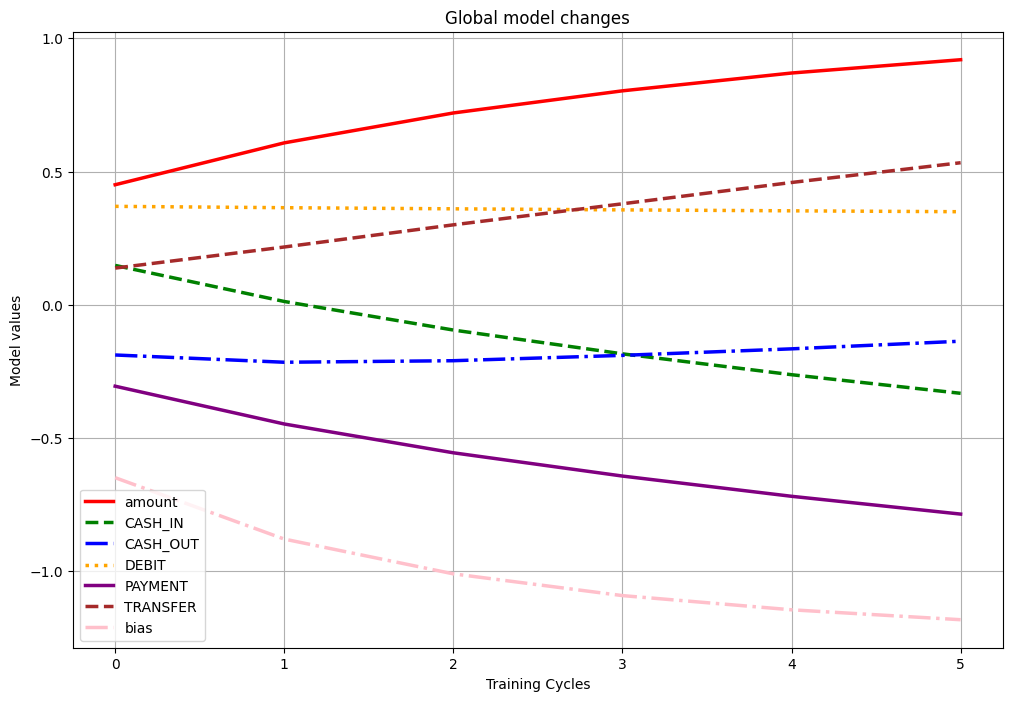

In [89]:
plot_model_changes(
    metrics_data = formatted_global_model_changes, 
    title = 'Global model changes',
    metrics = model_metrics
)

## Misc

In [4]:
formatted_df

,step,amount,nameOrig,nameDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud,isFlaggedFraud
0,1,9840,1,7233461,0,0,0,1,0,0,0
1,1,1864,2,7735206,0,0,0,1,0,0,0
2,1,181,3,8598945,0,0,0,0,1,1,0
3,1,181,4,7880837,0,1,0,0,0,1,0
4,1,11668,5,7670940,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682,6353303,6895525,0,1,0,0,0,1,0
6362616,743,6311409,6353304,7179249,0,0,0,0,1,1,0
6362617,743,6311409,6353305,7452283,0,1,0,0,0,1,0
6362618,743,850003,6353306,7284324,0,0,0,0,1,1,0


In [5]:
relevant_columns = [
    'amount',
    'type_CASH_IN',
    'type_CASH_OUT',
    'type_DEBIT',
    'type_PAYMENT',
    'type_TRANSFER',
    'isFraud'
]
relevant_df = formatted_df[relevant_columns]

In [7]:
worker_pool = relevant_df.iloc[:50000,:]
worker_pool

,amount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,9840,0,0,0,1,0,0
1,1864,0,0,0,1,0,0
2,181,0,0,0,0,1,1
3,181,0,1,0,0,0,1
4,11668,0,0,0,1,0,0
...,...,...,...,...,...,...,...
49995,1323,0,0,0,1,0,0
49996,6900,0,0,0,1,0,0
49997,17399,0,0,0,1,0,0
49998,5485,0,0,0,1,0,0
